## Part1: For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

#from shapely.geometry import Point
#import geopandas as gpd
#import folium
#from folium.plugins import MarkerCluster
#from folium.plugins import FastMarkerCluster

%matplotlib inline

/Users/armelleleguelte/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# to see all columns
pd.set_option('display.max_columns', None)

### 1-Using Json files:

In [4]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [5]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [6]:
#subsetting for case_request and case_subrequest

covid19 = hubNashville[hubNashville["case_subrequest"] == "COVID-19 Violations"]

In [7]:
covid19.shape

(11926, 19)

In [8]:
#drop columns
covid19 = covid19.drop(columns = ["additional_subrequest","case_subrequest", "case_origin", "mapped_location", "parent_case"], axis = 1)

In [9]:
covid19.shape

(11926, 14)

In [10]:
covid19.head(2)

,case_number,status,case_request,date_time_opened,state_issue,closed_when_created,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,date_time_closed,contact_type
0,503057,New,COVID-19,2020-11-14T16:28:56.000,False,False,136 Una Recreation Rd,NASHVILLE,29.0,37217.0,36.099009,-86.639050,NaN,NaN
1,503177,New,COVID-19,2020-11-14T23:55:58.000,False,False,2115 Belcourt Ave,NASHVILLE,18.0,37212.0,36.136562,-86.802239,NaN,NaN


### 2-Convert the time

In [11]:
#converting open to datetime
covid19['date_time_opened'] = [pd.to_datetime(d) for d in covid19['date_time_opened']]

In [12]:
# Converting the original date column from string to datetime
covid19["date_opened"] = covid19["date_time_opened"].dt.strftime('%Y-%m-%d')

In [13]:
# NB: there is missing values and this is why I can't convert the closed dates in integer (can't if Nan values) but I shouldn't need it for the project
#covid19[["month_closed", "day_closed"]] = covid19[["month_closed", "day_closed"]].apply(pd.to_numeric)
#covid19.info()

In [14]:
#covid19['month_opened'].value_counts().sort_index().plot(kind="bar");

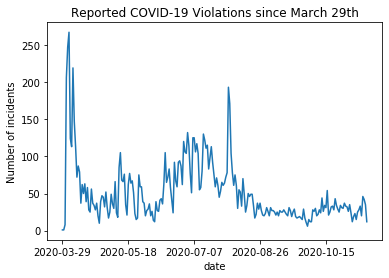

In [15]:
ax= covid19['date_opened'].value_counts().sort_index().plot(title='Reported COVID-19 Violations since March 29th')

ax.set_xlabel("date")
ax.set_ylabel("Number of incidents");

In [16]:
#covid19['log'] = covid19['GDP_Per_Capita'].apply(np.log)

## Part2: file davidson_cases.csv

### The file davidson_cases.csv contains the number of COVID cases in Davidson county per day from March 8 through October 29. Use this dataset to compare the trend for the number of cases over time to the number of reported violations. Feel free to add any additional data that you think might be useful.

In [17]:
davidson_cases = pd.read_csv("../data/davidson_cases.csv")
davidson_cases.head()

,date,county,state,fips,cases,deaths
0,2020-03-08,Davidson,Tennessee,47037,1,0
1,2020-03-09,Davidson,Tennessee,47037,1,0
2,2020-03-10,Davidson,Tennessee,47037,1,0
3,2020-03-11,Davidson,Tennessee,47037,2,0
4,2020-03-12,Davidson,Tennessee,47037,6,0


### 1-Convert the time

In [18]:
# Converting the original date column from string to datetime
davidson_cases["date"] = pd.to_datetime(davidson_cases['date'])

davidson_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    235 non-null    datetime64[ns]
 1   county  235 non-null    object        
 2   state   235 non-null    object        
 3   fips    235 non-null    int64         
 4   cases   235 non-null    int64         
 5   deaths  235 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.1+ KB


In [19]:
# setting datetime as index
davidson_cases = davidson_cases.set_index("date").sort_index()

### 2-Compare the number of cases and the number of reported violations over time:

In [27]:
covid19['date_opened'] = pd.to_datetime(covid19['date_opened'])

In [28]:
# making a df of month and day opened # from Taylor
violations_per_day = covid19['date_opened'].value_counts().to_frame()
violations_per_day = violations_per_day.sort_index()
violations_per_day = violations_per_day.rename(columns={'date_opened':'count'})

In [29]:
violations_per_day.head(3)

,count
2020-03-29,1
2020-03-30,1
2020-03-31,8


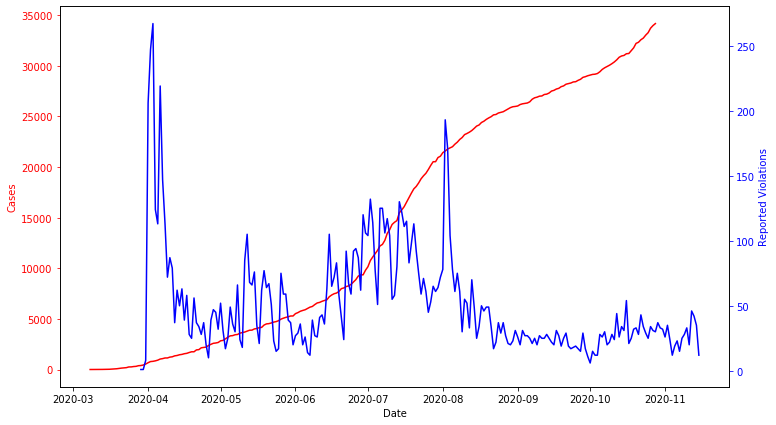

In [30]:
# from Taylor
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(davidson_cases.index, davidson_cases['cases'], 
           color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='red')
ax.tick_params('y', colors='red')
ax2 = ax.twinx()
ax2.plot(violations_per_day.index, violations_per_day['count'],          
         color='blue')
ax2.set_ylabel('Reported Violations', color='blue')
ax2.tick_params('y', colors='blue');

### 3-Exploring the number of deaths and cases over time:

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data= davidson_cases,x ="month_day",y="cases", hue="deaths");

In [ ]:
#plt.figure(figsize=(20,5))
#sns.scatterplot(data= davidson_cases,x ="month_day",y="cases", hue="deaths")
#plt.xticks(rotation = 45);

In [ ]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(davidson_cases['month_day'], davidson_cases['deaths'], 
           color='blue')
ax.set_xlabel('day')
ax.set_ylabel('Deaths', color='blue')
ax.tick_params('y', colors='blue')
ax2 = ax.twinx()
ax2.plot(davidson_cases['month_day'], davidson_cases['cases'],          
         color='red')
ax2.set_ylabel('Cases', color='red')
ax2.tick_params('y', colors='red');

In [ ]:
plt.figure(figsize=(9,5))

covid19['month_day_opened'].value_counts().sort_index().plot()

sns.lineplot(data= davidson_cases,x ="month_day",y="cases");

## Part3: The Metro Public Health Department tracks COVID-19 clusters.

### The files 'clusters.csv' and 'clusters_by_type.csv' contain the tables of clusters as reported by [WSMV](https://www.wsmv.com/news/metro-health-releases-latest-covid-19-clusters/article_ef554e08-1558-11eb-b290-873345e174d7.html) along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

### 1-Open cluster file

In [ ]:
cluster_by_type = pd.read_csv("../data/clusters_by_type.csv")
                              
cluster_by_type.head()

In [ ]:
cluster_by_type["Cluster Type"].unique()

In [ ]:
cluster_by_type = cluster_by_type.rename(columns = {"Cluster Type":"facility_type", "Number of Clusters":"number_clusters"})

In [ ]:
cluster_by_type.shape

### 2-Open cluster file

In [ ]:
cluster = pd.read_csv("../data/clusters_revised.csv")
cluster.head()

In [ ]:
cluster["Facility Type"].unique()

In [ ]:
cluster = cluster.rename(columns = {"Cluster Name":"cluster_name", "Facility Type":"facility_type","Cluster Start Date":"cluster_date", "# Cases":"#_cases", "Latitude":"latitude", "Longitude":"longitude"})

In [ ]:
cluster.head()

In [ ]:
#drop NaNs values in longitude and latitude columns
cluster = cluster.dropna() 

In [ ]:
cluster.shape

In [ ]:
# there is a comma before one longitude coordinate and I need to remove it and I'm using strip (not anymore with the revised file)
#cluster["longitude"] = cluster["longitude"].str.strip(",")

In [ ]:
# convert Longitude object to a float
#cluster["longitude"] = cluster.longitude.astype(float)

### 3-Merge cluster and cluster by type (NB: there is more categories in cluster by type so I will merge it on the cluster df)

In [ ]:
cluster_merge = cluster.merge(cluster_by_type, on="facility_type", how="left")

In [ ]:
cluster_merge.shape

### 4-Make the geometry column for geospatial:

In [ ]:
cluster_merge['geometry'] = cluster_merge.apply(lambda x: Point((float(x.longitude), 
                                                         float(x.latitude))), 
                                        axis=1)
cluster_merge.head(3)

### 5-Add davidson county with zipcodes

In [ ]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

In [ ]:
zipcodes.plot();

In [ ]:
zipcodes.crs

### 6-Make the geodataframe for cluster file and make a map:

In [ ]:
cluster_merge_geo = gpd.GeoDataFrame(cluster_merge, 
                           crs = zipcodes.crs, 
                           geometry = cluster_merge['geometry'])

In [ ]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=cluster_merge, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

### 7-Convert the covid19 violation file into a geodataframe:

In [ ]:
#drop NaNs values in longitude and latitude columns
covid19 = covid19.dropna() 

In [ ]:
covid19['geometry'] = covid19.apply(lambda x: Point((float(x.longitude), 
                                                         float(x.latitude))), 
                                        axis=1)
covid19.head(3)

In [ ]:
covid19_geo = gpd.GeoDataFrame(covid19, 
                           crs = zipcodes.crs, 
                           geometry = covid19['geometry'])

In [ ]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=covid19_geo, x="longitude", y="latitude", hue="case_request",palette="Set1");

#sns.scatterplot(data=cluster_merge_geo, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

### Making a heat map:

In [ ]:
covid19_merge = (covid19
          .drop(columns = 'geometry')
          .rename(columns = {'incident_zip_code': 'zip'})
         )

In [ ]:
# zip was a float
covid19_merge['zip'] = covid19_merge['zip'].astype(int)

In [ ]:
# to get the count per zipcode
covid19_merge_gpby = covid19_merge.groupby("zip")["closed_when_created"].agg('count')
covid19_merge_gpby.head()

In [ ]:
covid19_merge_gpby = covid19_merge_gpby.to_frame()

In [ ]:
covid19_merge_gpby = covid19_merge_gpby.reset_index()

In [ ]:
covid19_merge_gpby.head()

In [ ]:
zipcodes['zip'] = zipcodes['zip'].astype(int)

In [ ]:
zipcodes_covid19_merge = pd.merge(left = covid19_merge, right = zipcodes)

In [ ]:
zipcodes_covid19_merge.head(2)

In [ ]:
zipcodes_covid19_merge_gpby = zipcodes.merge(covid19_merge_gpby, on="zip", how="outer")

In [ ]:
zipcodes_covid19_merge_gpby.head()

In [ ]:
zipcodes_covid19_merge_gpby['closed_when_created'] = zipcodes_covid19_merge_gpby['closed_when_created'].fillna(0)

In [ ]:
zipcodes_covid19_merge_gpby['closed_when_created'] = zipcodes_covid19_merge_gpby['closed_when_created'].astype(int)

In [ ]:
#Heat map of covid violations per zipcodes in davidson county

fig, ax = plt.subplots(figsize=(10,10))
zipcodes_covid19_merge_gpby.plot(column = 'closed_when_created', 
                                 cmap = 'Reds', 
                                 edgecolor = 'black', 
                                 legend = True,
                                 ax = ax);

### 8-Map covid-19 violations and clusters cases on the davidson shape map:

In [ ]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=covid19_geo, x="longitude", y="latitude", hue="case_request",palette="Set1");

sns.scatterplot(data=cluster_merge_geo, x="longitude", y="latitude", hue="#_cases", palette="mako_r", size="#_cases", sizes=(10, 200), edgecolor = 'black');

## Use Folium

In [ ]:
#zipcodes.geometry.centroid

In [ ]:
center = zipcodes.geometry.centroid[1]
print(center)

In [ ]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

### 1- Map of the # of covid19 positive cases per day in davidson county:

In [ ]:
#draw zipcode area
map_davidson = folium.Map(location =  area_center, zoom_start = 12)


#iterate through clusters to create locations and markers 
#remember for Folium locations, lat is listed first!!

for row_index, row_values in cluster_merge_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['#_cases'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color="blue",icon_color='white',icon = "certificate")) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')


#display our map
map_davidson

In [ ]:
cluster_merge_geo.facility_type.unique()

In [ ]:
# (Map will be centered at those co-ordinates)
map = folium.Map(location=[36.148465, -86.767960], default_zoom_start=10)

#Icon should be one of: {'darkred', 'lightred', 'pink', 'gray', 'lightblue', 'blue', 'red', 'lightgreen', 'darkblue' 
#, 'cadetblue', 'beige', 'green', 'lightgray', 'white', 'black', 'purple', 'orange', 'darkgreen', 'darkpurple'}.

# Function to change the marker color  
def color(facility): 
    if facility == 'Social Gathering': 
        col = 'orange'
    elif facility == 'LTCF': 
        col = 'green'
    elif facility == 'Commercial-Warehouse': 
        col = 'darkblue'
    elif facility == 'Congregate Living': 
        col = 'lightgreen'
    elif facility == 'Construction': 
        col = 'red'
    elif facility == 'Correctional Facility': 
        col = 'black'
    elif facility == 'Bar': 
        col = 'blue'
    elif facility == 'Restaurant': 
        col = 'lightgblue'
    elif facility == 'Office': 
        col = 'gray'
    elif facility == 'Church': 
        col = 'pink'
    elif facility == 'Gym': 
        col = 'purple'
    else: 
        col='white'
    return col

for row_index, row_values in cluster_merge_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['facility_type'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color=color(facility), 
                  icon_color='lightgray',icon = 'certificate')) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')


#display our map
map_davidson

In [ ]:
map = folium.Map(location=[36.148465, -86.767960], default_zoom_start=50) # from Kedir
map

### 2- Map of covid19 violations reported per day in davidson county:

In [ ]:
#draw zipcode area
map_davidson = folium.Map(location =  area_center, zoom_start = 12)

#folium.GeoJson(zipcodes).add_to(map_davidson)

#iterate through #_cases to create locations and markers for covid cluster
#remember for Folium locations, lat is listed first!!

for row_index, row_values in covid19_geo.iterrows():
    loc = [row_values['latitude'], row_values['longitude']]
    pop = str(row_values['case_request'])
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon= folium.Icon(color="red",icon_color='white',icon = "hand-down")) 
    
    marker.add_to(map_davidson)
#map_davidson.save('../maps/map_davidson.html')

#display our map
map_davidson

In [ ]:
#draw our zip code area: 37207
map_davidson = folium.Map(location =  area_center, zoom_start = 12)

#folium.GeoJson(zipcodes).add_to(map_davidson)

#create a list of locations and pass them to FastMarkerCluster()
locations = covid19_geo[['latitude', 'longitude']].values.tolist()
map_davidson.add_child(
    FastMarkerCluster(locations)
)

#display our map
map_davidson

## Part 4:

In [ ]:
import glob
from pandas.io.json import json_normalize

In [ ]:
google_results = pd.DataFrame() #create empty dataframe
for filename in glob.glob('../data/google_places_results/*.json'): # loop over .json files
    with open(filename) as f:
        google_files = json.load(f) # open the json file
        google_jsons = pd.json_normalize(google_files, sep='_', #normalize the json file for nested results
                            record_path='results')
        google_results = google_results.append(google_jsons) #append each json file results to df

In [ ]:
#selecting only the columns we want
google_results = google_results[['name', 'types', 'vicinity', 'geometry_location_lat', 'geometry_location_lng']].reset_index(drop=True)

In [ ]:
#renaming columns in preparation for merge
google_results = google_results.rename(columns={'vicinity': 'google_address', 
                               'geometry_location_lat': 'latitude',
                               'geometry_location_lng': 'longitude'})

In [ ]:
#merging hubNashville with google_results
violations_google_results = covid19.merge(google_results, on=['latitude', 'longitude'])

In [ ]:
#removing duplicates that have the same date_time_opened, latitude, and longitude
violations_google_results = violations_google_results.drop_duplicates(subset=['date_time_opened','latitude', 'longitude']).reset_index(drop=True)

In [ ]:
violations_google_results.head()

In [ ]:
violations_google_results.shape

In [ ]:
violations_google_results['name'].value_counts().head(15).plot(kind='barh',
                                                              title='Most Violations from Middle TN Businesses');


In [ ]:
violations_google_results['name'].value_counts()